# PHYS 512 - Problem Set 5

**André Vallières (260742187)**

## Problem 1

In [168]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import integrate, signal

### a)

#### Code for reading files

In [134]:
EVENTS_DIRECTORY = 'LOSC_Event_tutorial/'

FILES = [
    {
        "name": "GW150914",
        "event_H": "H-H1_LOSC_4_V2-1126259446-32.hdf5",
        "event_L": "L-L1_LOSC_4_V2-1126259446-32.hdf5",
        "template": "GW150914_4_template.hdf5"
    },
    {
        "name": "LVT151012",
        "event_H": "H-H1_LOSC_4_V2-1128678884-32.hdf5",
        "event_L": "L-L1_LOSC_4_V2-1128678884-32.hdf5",
        "template": "LVT151012_4_template.hdf5"
    },
    {
        "name": "GW151226",
        "event_H": "H-H1_LOSC_4_V2-1135136334-32.hdf5",
        "event_L": "L-L1_LOSC_4_V2-1135136334-32.hdf5",
        "template": "GW151226_4_template.hdf5"
    },
    {
        "name": "GW170104",
        "event_H": "H-H1_LOSC_4_V1-1167559920-32.hdf5",
        "event_L": "L-L1_LOSC_4_V1-1167559920-32.hdf5",
        "template": "GW170104_4_template.hdf5"
    }
]

def read_template(filename):
    dataFile = h5py.File(os.path.join(EVENTS_DIRECTORY, filename), 'r')
    template = dataFile['template']
    th = template[0]
    tl = template[1]
    return th, tl

def read_file(filename):
    dataFile = h5py.File(os.path.join(EVENTS_DIRECTORY, filename), 'r')
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]

    meta = dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart = meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc = meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration = meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain = dataFile['strain']['Strain'][()]
    dt = (1.0 * duration) / len(strain)

    dataFile.close()
    
    return strain, dt, utc

#### Noise models

In [135]:
def gaussian_smooth(x, std=1):
    # Convert input to frequency domain
    fft = np.fft.fft(x)
    
    # Prepare a Gaussian
    n = np.arange(len(x))
    gaussian = np.exp(-0.5 * (n/std)**2)
    gaussian = gaussian + gaussian[::-1]
    gaussian = gaussian/np.sum(gaussian) # Normalization
    
    # Convert kernel to frequency domain
    gaussian_fft = np.fft.fft(gaussian)

    # Convolve with Gaussian kernel
    return np.abs(np.fft.ifft(fft * gaussian_fft))

def get_noise_models(std=5, alpha=0.125, plot=True):
    noise_models = []
    for file in FILES:
        event_H = file["event_H"]
        event_L = file["event_L"]
        template = file["template"]

        # Read files
        H_strain, H_dt, _ = read_file(event_H)
        L_strain, L_dt, _ = read_file(event_L)

        H_template, L_template = read_template(template)

        # Get window to eliminate effects of non-periodic boundaries in the data
        window = signal.tukey(len(H_strain), alpha) # Tapered in the center

        # Window both signals and templates
        H_strain = H_strain * window
        L_strain = L_strain * window

        H_template = H_template * window
        L_template = L_template * window

        # Use of Welch's method (better spectrogram estimation)
        fs = 1.0/H_dt # 4096
        H_freqs, H_noise = signal.welch(H_strain, fs, window="blackman", nperseg=4 * fs) # 4 sec
        L_freqs, L_noise = signal.welch(L_strain, fs, window="blackman", nperseg=4 * fs)

        # Smooth
        H_noise_smooth = gaussian_smooth(H_noise, std)
        L_noise_smooth = gaussian_smooth(L_noise, std)

        template_fft = np.fft.rfft(H_template)
                    
        # Store models
        template = read_template(template)
        noise_models.append({
            "name": file["name"],
            "H_noise": H_noise_smooth,
            "L_noise": L_noise_smooth,
            "H_freqs": H_freqs,
            "L_freqs": L_freqs,
            "H_strain": H_strain,     # windowed
            "L_strain": L_strain,     # windowed
            #"window": window,
            "H_template": H_template, # windowed
            "L_template": L_template, # windowed
            "H_dt": H_dt,
            "L_dt": L_dt
        })

        # Plot
        if plot:
            print("Event ::", file["name"])
            
            plt.figure()
            plt.loglog(H_freqs, np.sqrt(H_noise))
            plt.loglog(H_freqs, np.sqrt(H_noise_smooth))
            plt.legend(["Hanford", "Hanford smoothed"])
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'Power density (strain/$\sqrt{Hz}$)')
            plt.show()

            plt.figure()
            plt.loglog(L_freqs, np.sqrt(L_noise))
            plt.loglog(L_freqs, np.sqrt(L_noise_smooth))
            plt.legend(["Livingston", "Livingston smoothed"])
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'Power density (strain/$\sqrt{Hz}$)')
            plt.show()

            plt.figure()
            plt.loglog(H_freqs, np.sqrt(H_noise_smooth))
            plt.loglog(L_freqs, np.sqrt(L_noise_smooth))
            plt.legend(["Hanford smoothed", "Livingston smoothed"])
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'Power density (strain/$\sqrt{Hz}$)')
            plt.show()
            
    return noise_models

Event :: GW150914


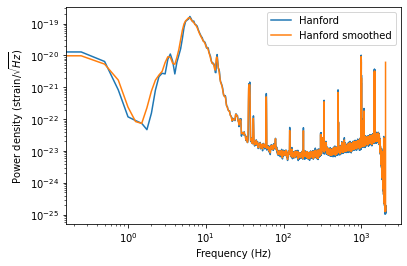

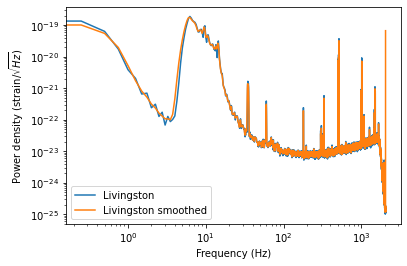

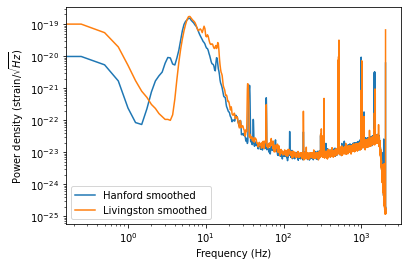

Event :: LVT151012


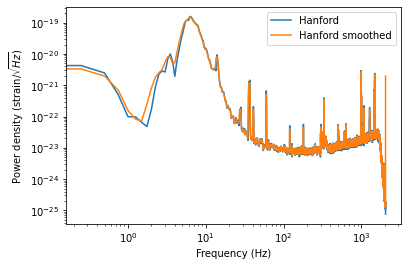

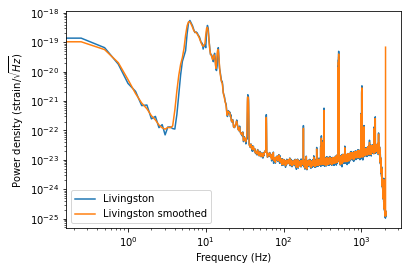

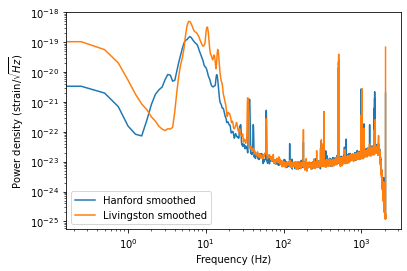

Event :: GW151226


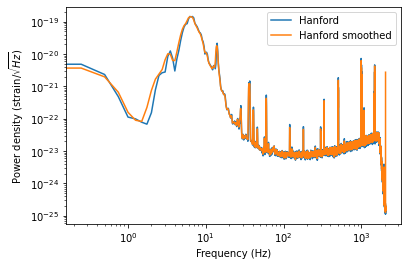

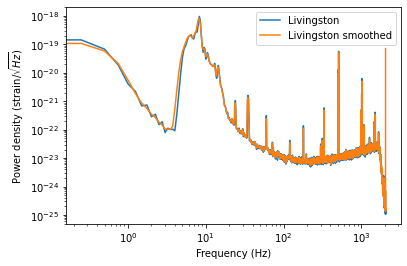

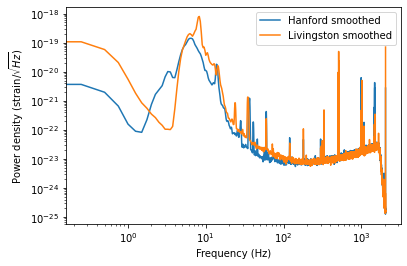

Event :: GW170104


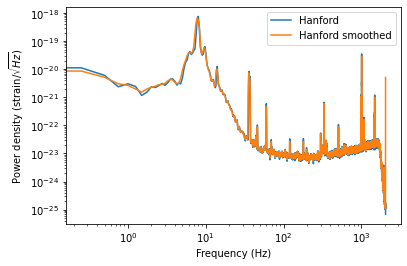

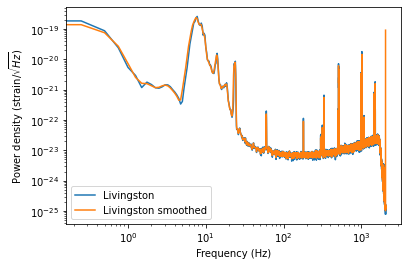

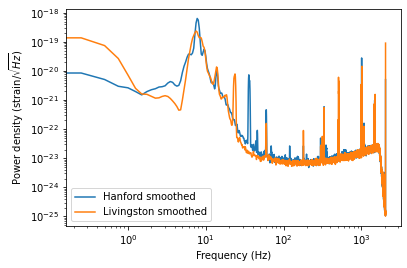

In [136]:
noise_models = get_noise_models(std=0.5, alpha=0.125);

In the above code, I chose to use a Tukey window since it is tapered in the center. I've played with the $\alpha$ parameter to visually fit the power spectrum to the way shown in the slides (and tutorial). Note that we show frequencies up to 2 kHz since, from Nyquist theorem, only frequencies up to 2048 Hz can be correctly represented (because the sampling rate is 4 kHz). Then, the spectrums are smoothed by convoluting them with a Gaussian (with varying width; "optimal" parameter found visually). The final step, as shown in class, is to make sure peaks are kept so we take the maximum at each value.

### b) & c)

#### Matched filter method

In [195]:
def get_matched_filter(event):
    ### 
    # Hanford
    ###
    
    # FFTs
    Aft = np.fft.fft(event['H_template']) # FFT (windowed) template
    freqs = np.fft.fftfreq(event['H_template'].size, d=event['H_dt'])
    
    sft = np.fft.fft(event['H_strain']) # FFT (windowed) data
    
    # Get interpolated noise
    H_noise = np.interp(np.abs(freqs), event['H_freqs'], event['H_noise'])
    
    # Matched filter
    mf_ft_H = np.conj(Aft) * sft / H_noise # Matched filter
        
    ### 
    # Livingston
    ###
    
    # FFTs
    Aft = np.fft.fft(event['L_template']) # FFT (windowed) template
    freqs = np.fft.fftfreq(event['L_template'].size, d=event['L_dt'])
    
    sft = np.fft.fft(event['L_strain']) # FFT (windowed) data
    
    # Get interpolated noise
    L_noise = np.interp(np.abs(freqs), event['L_freqs'], event['L_noise'])
    
    # Matched filter
    mf_ft_L = np.conj(Aft) * sft / L_noise # Matched filter
    
    return (mf_ft_H, mf_ft_L)

def get_SNR(event, plot=True):
    mf_ft_H, mf_ft_L = get_matched_filter(event)
    
    ###
    # Hanford
    ###
    mf = np.fft.irfft(mf_ft_H)
    rolled_mf = np.roll(np.abs(mf), len(mf)//2 - np.argmax(np.abs(mf)))
    
    # SNR
    H_SNR_1 = np.abs((np.max(mf) - np.mean(mf))/np.std(mf)) # Estimate 1
    
    Aft_ft = np.abs(np.conj(Aft) * Aft / H_noise)
    df = np.abs(freqs[1] - freqs[0])
    std = np.sqrt(np.sum(Aft_ft) * df)
    H_SNR_2 = np.max(np.abs(mf)/std) # Estimate 2
    
    if plot:
        plt.figure()
        plt.plot(rolled_mf/std)
        plt.title("Hanford matched filter")
        plt.show()
        
        print("Hanford SNR (estimate 1) ::", H_SNR_1)
        print("Hanford SNR (estimate 2) ::", H_SNR_2)
        
    ###
    # Livingston
    ###
    mf = np.fft.irfft(mf_ft_L)
    rolled_mf = np.roll(np.abs(mf), len(mf)//2 - np.argmax(np.abs(mf)))
    
    # SNR
    L_SNR_1 = np.abs((np.max(mf) - np.mean(mf))/np.std(mf)) # Estimate 1
    
    Aft_ft = np.abs(np.conj(Aft) * Aft / L_noise)
    df = np.abs(freqs[1] - freqs[0])
    std = np.sqrt(np.sum(Aft_ft) * df)
    L_SNR_2 = np.max(np.abs(mf)/std) # Estimate 2
    
    if plot:
        plt.figure()
        plt.plot(rolled_mf/std)
        plt.title("Livingston matched filter")
        plt.show()
        
        print("Livingston SNR (estimate 1) ::", L_SNR_1)
        print("Livingston SNR (estimate 2) ::", L_SNR_2)
        
        print("\nCombined SNR (estimate 1) ::", np.sqrt(H_SNR_1 ** 2 + L_SNR_1 ** 2))
        print("Combined SNR (estimate 2) ::", np.sqrt(H_SNR_2 ** 2 + L_SNR_2 ** 2))
        
    return ((H_SNR_1, L_SNR_1), (H_SNR_2, L_SNR_2))

#### Grid search for optimal SNR

I had to be careful not to artificially boost the SNR so I restrict the range to not have insanely high (artificial) SNR. (That's why I chose to not vary alpha)

In [153]:
# Grid search
std_range = np.linspace(0.05, 5.0, 21)

opt_SNR = 0
opt_std = 0

for std in std_range:
    # Get noise models
    noise_models = get_noise_models(std, plot=False)

    # Compute average SNR (using only second estimate)
    SNR = np.average([x[1] for x in [get_SNR(event, plot=False) for event in noise_models]])

    # Save new parameters if better SNR
    if SNR > opt_SNR:
        opt_SNR = SNR
        opt_std = std

        print("New optimal parameters found:")
        print("\tOptimal std ::", opt_std)
        print("\tSNR ::", opt_SNR)
        print("")
            
print("Optimal std ::", opt_std)
print("SNR ::", opt_SNR)

New optimal parameters found:
	Optimal std :: 0.05
	SNR :: 6.276224027530734

New optimal parameters found:
	Optimal std :: 1.2875
	SNR :: 6.277162248107551

New optimal parameters found:
	Optimal std :: 1.535
	SNR :: 6.28038577186298

Optimal std :: 1.535
SNR :: 6.28038577186298


#### Matched filter with optimal parameters


Event :: GW150914


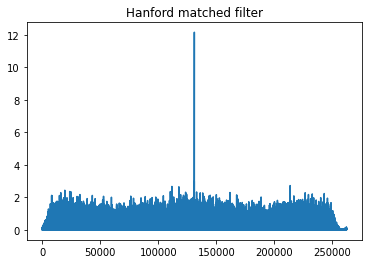

Hanford SNR (estimate 1) :: 14.541965554192933
Hanford SNR (estimate 2) :: 12.162566359169384


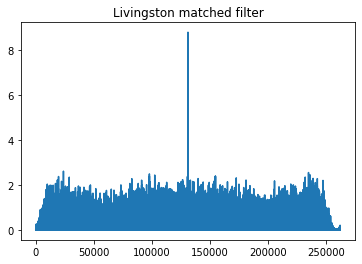

Livingston SNR (estimate 1) :: 18.269167709738014
Livingston SNR (estimate 2) :: 8.788112996511062

Combined SNR (estimate 1) :: 23.350187386525786
Combined SNR (estimate 2) :: 15.005297413935034

Event :: LVT151012


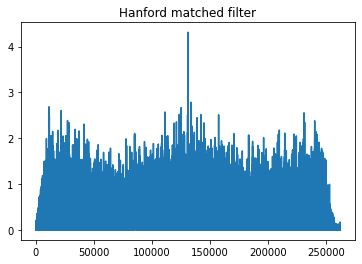

Hanford SNR (estimate 1) :: 9.088123160112195
Hanford SNR (estimate 2) :: 4.313548152017097


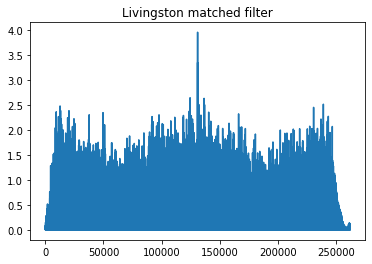

Livingston SNR (estimate 1) :: 8.2373236238599
Livingston SNR (estimate 2) :: 3.9534943245605305

Combined SNR (estimate 1) :: 12.265703528846933
Combined SNR (estimate 2) :: 5.851223379268855

Event :: GW151226


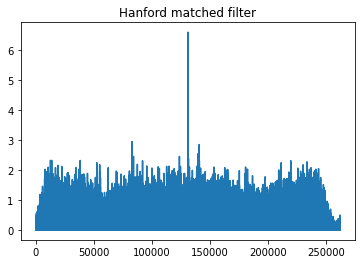

Hanford SNR (estimate 1) :: 13.856360552280252
Hanford SNR (estimate 2) :: 6.592126960418376


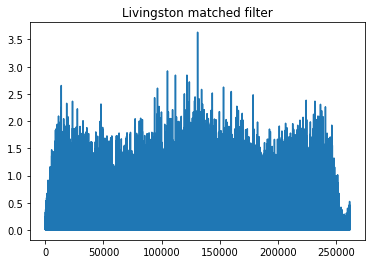

Livingston SNR (estimate 1) :: 7.534283664664546
Livingston SNR (estimate 2) :: 3.633226991482017

Combined SNR (estimate 1) :: 15.772259130968504
Combined SNR (estimate 2) :: 7.527049636737378

Event :: GW170104


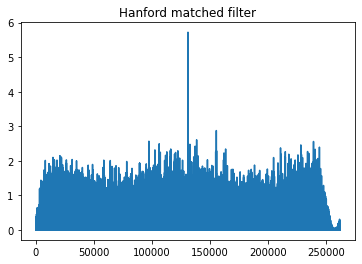

Hanford SNR (estimate 1) :: 5.457996838473795
Hanford SNR (estimate 2) :: 5.719108593991172


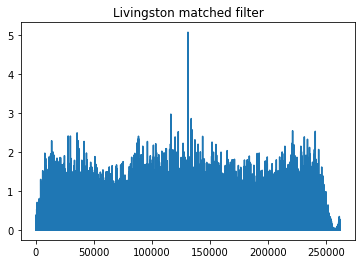

Livingston SNR (estimate 1) :: 9.472943833943349
Livingston SNR (estimate 2) :: 5.080901796754203

Combined SNR (estimate 1) :: 10.932812738258862
Combined SNR (estimate 2) :: 7.650082756292494


In [157]:
# Noise models
noise_models = get_noise_models(opt_std, plot = False)

# Matched filter
for event in noise_models:
    print("\nEvent ::", event["name"])
    
    get_SNR(event, plot=True)

### d)

There are two ways that we've measured the SNR:
1) By simply taking the matched filter output (mf) and comparing its maximum to the noise (N):
\begin{equation}
\text{SNR}_1 = \frac{\text{max(mf)} - \text{avg(mf)}}{\text{std(mf)}}
\end{equation}

2) By using the noise in the template (A), normalize the matched filter output and extract the SNR as the maximum:
\begin{equation}
\text{SNR}_2 = \text{max} \Big\{ \frac{\text{mf}}{\sigma} \Big\} = \text{max} \Bigg\{ \frac{\text{mf}}{\sqrt{\tilde{\text{A}}^* \cdot \tilde{\text{A}}}} \Bigg\} = \text{max} \Bigg\{ \frac{\text{mf}}{\sqrt{\text{A}^* \cdot \text{A} \cdot N^{-1}}} \Bigg\}
\end{equation}

Generally, we've seen that the first method gives higher result (but not incredibly higher than the second method) since the standard deviation of matched filter output is not a great estimate of the noise, mainly due to artificial decrease of the noise from windowing. The second method seems more accurate.

### e)

In [196]:
def get_signal_freq(freqs, mf_ft):
    """
    Looking at the matched filter FFT, take the frequency for which
    the cumulative sum is half of the total cumulative sum
    """
    mf_ft = mf_ft[:len(mf_ft)//2]
    freqs = freqs[:len(mf_ft)]
    df = freqs[1] - freqs[0]

    cs = integrate.cumtrapz(np.abs(mf_ft), dx=df, initial=0)

    return freqs[(cs < max(cs)/2).sum()]
    
sig_freqs = []
for event in noise_models:    
    print("\nEvent ::", event["name"])
    
    # Matched filter
    mf_ft_H, mf_ft_L = get_matched_filter(event)

    sig_freq = get_signal_freq(freqs, mf_ft_H)
    sig_freqs.append(sig_freq)
    print("Hanford signal frequency ::", sig_freq)

    sig_freq = get_signal_freq(freqs, mf_ft_L)
    sig_freqs.append(sig_freq)
    print("Livingston signal frequency ::", sig_freq)
    
print("\nAverage signal frequency ::", np.average(sig_freqs))


Event :: GW150914
Hanford signal frequency :: 130.5
Livingston signal frequency :: 135.4375

Event :: LVT151012
Hanford signal frequency :: 121.4375
Livingston signal frequency :: 130.09375

Event :: GW151226
Hanford signal frequency :: 142.09375
Livingston signal frequency :: 172.21875

Event :: GW170104
Hanford signal frequency :: 132.25
Livingston signal frequency :: 113.6875

Average signal frequency :: 134.71484375


We see that the signal frequency was found to be, on average, around 134 Hz. This agrees with data from LIGO.

### f)

We will look at the matched filter in the time domain since this is how we determine the time of arrival of the gravitational wave.

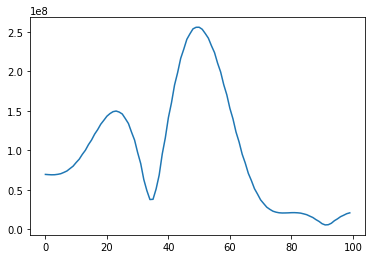

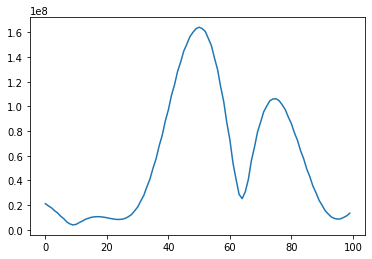

In [214]:
# Matched filter
mf_ft_H, mf_ft_L = get_matched_filter(noise_models[0])

# Convert to time and smooth
mf_H = gaussian_smooth(np.abs(np.fft.irfft(mf_ft_H)))
mf_L = gaussian_smooth(np.abs(np.fft.irfft(mf_ft_L)))

# Look around peak
max_H = np.argmax(mf_H)
max_L = np.argmax(mf_L)
win = 50

plt.plot(mf_H[max_H - win:max_H + win])
plt.show()

plt.plot(mf_L[max_L - win:max_L + win])
plt.show()

Ideally, we could do this exercise for each event, fit a gaussian on each event then compute the FWHM. However, since all we want is an approximate value (and the aforementioned process would of course have some uncertainties) then we can just eyeball the value from the above two plots. The FWHM is around 20 values.

In [225]:
FWHM = 20 * event['H_dt']
print("Time uncertainty :: %f s" % FWHM)

Time uncertainty :: 0.004883 s


Assuming this is our uncertainty in time, then our uncertainty in position is around $c\Delta t$

In [226]:
c = 3e5 # km/s
print("Positional uncertainty :: %f km" % (c * FWHM))

Positional uncertainty :: 1464.843750 km


I do agree that all of this is really hand-wavy arguments and a more precise description would require more thought.